In [6]:
using CSV
using NPZ
using Glob
using PyPlot
using Eirene
using Statistics
using DataFrames
using DelimitedFiles

#### Helper functions

In [7]:
function load_postion_data(day, spot, frame)
    tracking_data_file = "YuLong_Data/day_" * day * "/" * spot * "spot.csv"
    tracking_data = CSV.read(tracking_data_file)
    max_frame = maximum(tracking_data[!, :FRAME])
    @assert(frame <= max_frame)
    idx_frame = findall(convert(Array{Bool}, tracking_data[!, :FRAME] .== frame))
    pos_x = tracking_data[idx_frame, :POSITION_X] 
    pos_y = tracking_data[idx_frame, :POSITION_Y] 
    pos_z = tracking_data[idx_frame, :POSITION_Z]
    return [pos_x pos_y pos_z]
end

function get_max_frame(day, spot)
    tracking_data_file = "YuLong_Data/day_" * day * "/" * spot * "spot.csv"
    tracking_data = CSV.read(tracking_data_file)
    max_frame = maximum(tracking_data[!, :FRAME])
    return max_frame
end

function get_cell_displacements(day, spot, frame)
    tracking_data_file = "YuLong_Data/day_" * day * "/" * spot * "spot.csv"
    tracking_data = CSV.read(tracking_data_file)
    idx_frame_prev = findall(convert(Array{Bool}, tracking_data[!, :FRAME] .== (frame-1)))
    idx_frame_cur = findall(convert(Array{Bool}, tracking_data[!, :FRAME] .== frame))
    id_list_cur = tracking_data[idx_frame_cur, :TRACK_ID]
    id_list_prev = tracking_data[idx_frame_prev, :TRACK_ID]
    common_track_idx = findall(in(id_list_prev), id_list_cur)
    data_subset_cur = tracking_data[idx_frame_cur,:]
    data_subset_cur = data_subset_cur[common_track_idx,:]
    data_subset_prev = tracking_data[idx_frame_prev,:]
    tracks_cur = data_subset_cur[!, :TRACK_ID]
    displacements = []
    distances = []
    track_ids = []
    for tc in tracks_cur
        tc_data = data_subset_cur[data_subset_cur[!,:TRACK_ID] .== tc, :]
        tp_data = data_subset_prev[data_subset_prev[!,:TRACK_ID] .== tc, :]
        @assert(size(tc_data)[1] == 1)
        @assert(size(tp_data)[1] == 1)
        cell_c_x = tc_data[!,:POSITION_X][1]
        cell_c_y = tc_data[!,:POSITION_Y][1]
        cell_c_z = tc_data[!,:POSITION_Z][1]
        cell_p_x = tp_data[!,:POSITION_X][1]
        cell_p_y = tp_data[!,:POSITION_Y][1]
        cell_p_z = tp_data[!,:POSITION_Z][1]
        dist_travelled = sqrt((cell_c_x - cell_p_x)^2 + (cell_c_y - cell_p_y)^2 + (cell_c_z - cell_p_z)^2)
        if dist_travelled > 10
            write(stderr, "WARNING: Day " * day * " Spot " * spot * " ")
            write(stderr, "Track ID " * string(tc) * " Frame " * string(frame) * " ")
            write(stderr, "Distance travelled: " * string(round(dist_travelled, digits=2)) * " um\n")
        end
        append!(track_ids, tc)
        append!(distances, dist_travelled)
        append!(displacements, [[cell_p_x, cell_p_y, cell_p_z, cell_c_x, cell_c_y, cell_c_z]])
    end
    return (distances, displacements, track_ids)  
end

function plot_persistence_diag(dim0barcode_data, dim1barcode_data, dim2barcode_data, x_lim=nothing, y_lim=nothing)
    dim0_bar_lengths = dim0barcode_data[:,2] - dim0barcode_data[:,1]
    max_dim1_x = maximum(dim1barcode_data[:,1])
    max_dim2_x = maximum(dim2barcode_data[:,1])
    max_x = maximum([max_dim1_x, max_dim2_x])
    max_y = 0.0
    figure(figsize=(5,5), dpi=600)
    for i in range(1, length=length(dim0_bar_lengths))
        len = dim0_bar_lengths[i]
        if len != Inf
            if len > max_y
                max_y = len
            end
            scatter(dim0barcode_data[i,1], dim0barcode_data[i,2], color=:darkblue, s=16)
        end
    end
    max_dim1_y = maximum(dim1barcode_data[:,2])
    max_dim2_y = maximum(dim2barcode_data[:,2])
    max_y = maximum([max_y, max_dim1_y, max_dim2_y])
    scatter(dim1barcode_data[:,1], dim1barcode_data[:,2], color=:darkorange, s=16)
    scatter(dim2barcode_data[:,1], dim2barcode_data[:,2], color=:darkgreen, s=16)
    max_plot_len = maximum([max_x, max_y])
    plot([0, max_plot_len+2], [0, max_plot_len+2], color=:black, "--")
    if isnothing(x_lim)
        xlim([-0.5, max_x+0.5])
    else
        xlim([-0.5, x_lim+0.5])
    end
    if isnothing(y_lim)
        ylim([-0.5, max_y+0.5])
    else
        ylim([-0.5, y_lim+0.5])
    end
    scatter(0.0, max_y+0.5-0.05, color=:darkblue, s=16)
    xlabel(L"$\epsilon$")
    ylabel(L"$\epsilon$")
    show()
end;

#### Analyze collective behavior on day 5
- Track cell nuclei
- Identify lumens
- Plot population statistics

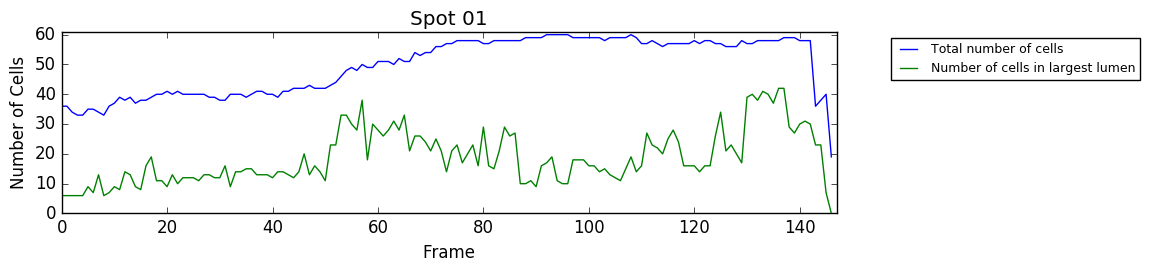

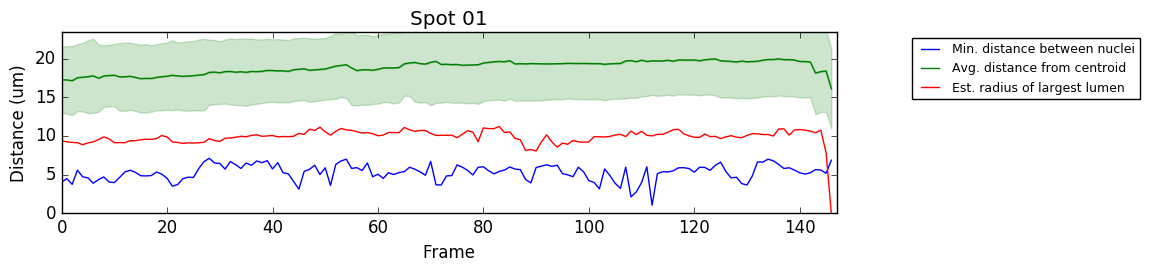

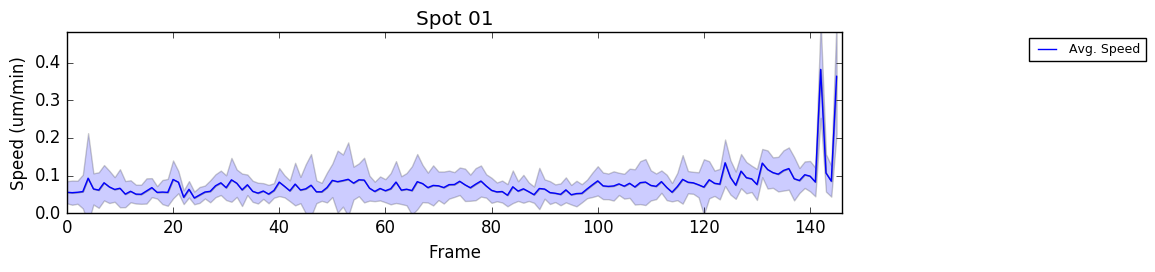

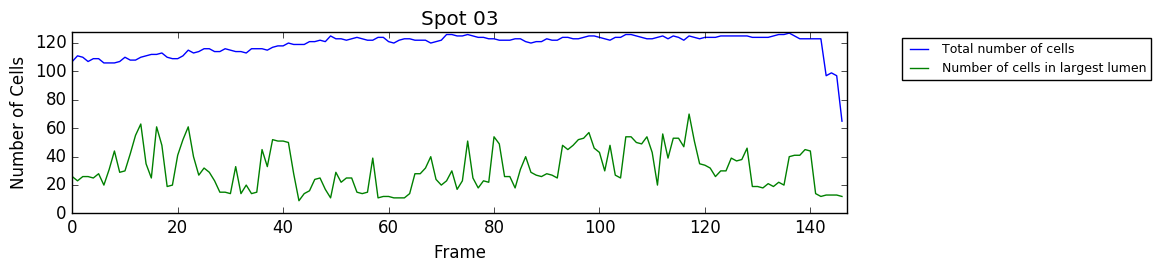

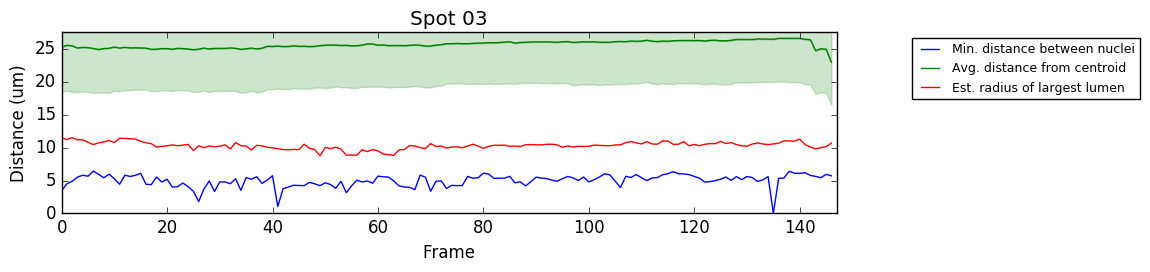

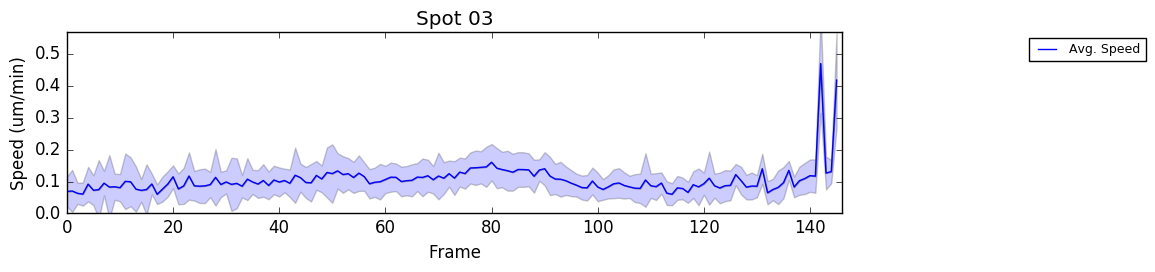

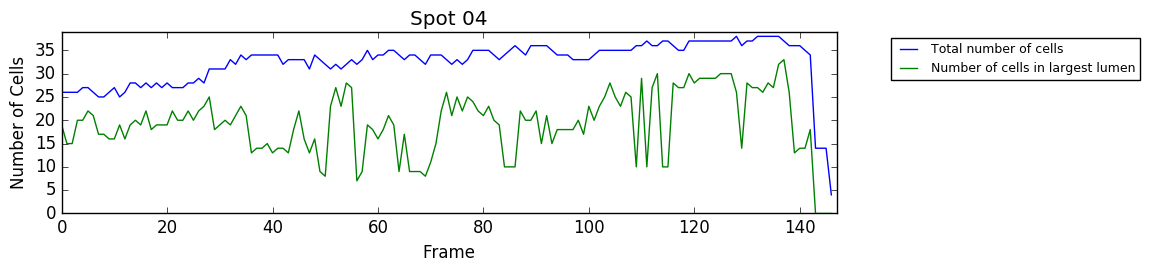

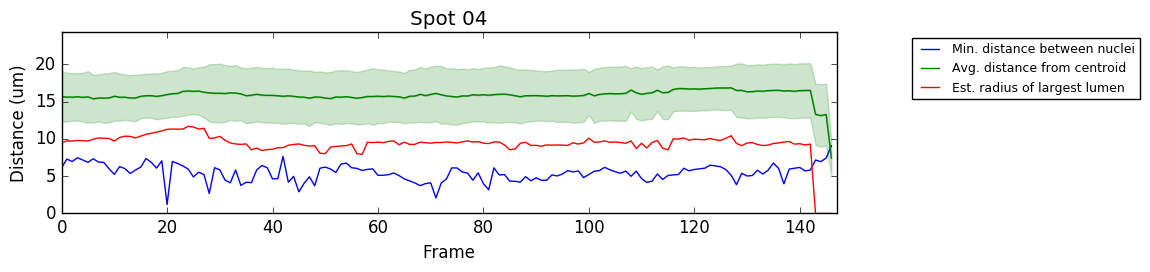

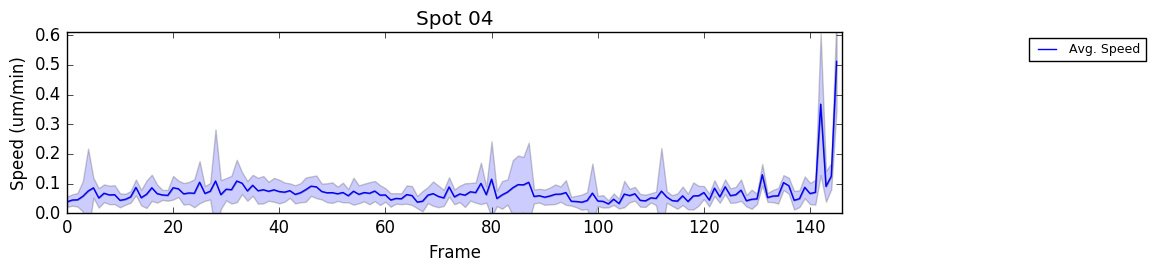

In [8]:
day5_data = glob("*.csv", "YuLong_Data/day_5/");

for fp in day5_data[1:4]
    
    filename = split(fp, "/")[end]
    fnameparts = split(filename, "spot")
    if (length(fnameparts) != 2)
        continue
    end
    spotstring = fnameparts[1]
    max_frame = get_max_frame("5", spotstring)
    
    numcells = []
    largest_lumen = []
    largest_lumen_diameter = []
    shortest_dist = []
    avg_dist_COM = []
    std_dist_COM = []
    avg_speed = []
    std_speed = []
    
    for tp in range(0, stop=max_frame)
        
        cell_positions = load_postion_data("5", spotstring, tp)
        if tp > 0
            (distances, displacements, track_ids) = get_cell_displacements("5", spotstring, tp)
            append!(avg_speed, mean(distances)/15)
            append!(std_speed, std(distances/15))
        end
        
        population = size(cell_positions)[1]
        CoM_X = sum(cell_positions[:,1])/population
        CoM_Y = sum(cell_positions[:,2])/population
        CoM_Z = sum(cell_positions[:,3])/population
        append!(numcells, population)
        
        CoM_dists = []
        for cid in range(1, stop=population)
            cp = cell_positions[cid,:]
            CoM_dist = sqrt((cp[1]-CoM_X)^2 + (cp[2]-CoM_Y)^2 + (cp[3]-CoM_Z)^2)
            append!(CoM_dists, CoM_dist)
        end
        append!(avg_dist_COM, mean(CoM_dists))
        append!(std_dist_COM, std(CoM_dists))
        
        if population > 1
            TDA_diag = eirene(transpose(cell_positions), model="pc", maxdim=2)
            TDA_barcode_dim0 = barcode(TDA_diag, dim=0)
            TDA_barcode_dim2 = barcode(TDA_diag, dim=2)
            if size(TDA_barcode_dim2)[1] >= 1
                dim2_bar_lengths = TDA_barcode_dim2[:,2] - TDA_barcode_dim2[:,1]
                s_idx = sortperm(dim2_bar_lengths, alg=QuickSort)
                dim2_largest_hole = classrep(TDA_diag, class=s_idx[end], dim=2)
                append!(largest_lumen, length(unique(dim2_largest_hole)))
                dim2barcode_sorted_inc = TDA_barcode_dim2[s_idx,:]
                append!(largest_lumen_diameter, dim2barcode_sorted_inc[end,2])
            else
                append!(largest_lumen, 0)
                append!(largest_lumen_diameter, 0)
            end
            dim0_bar_lengths = TDA_barcode_dim0[:,2] - TDA_barcode_dim0[:,1]
            s_idx = sortperm(dim0_bar_lengths, alg=QuickSort)
            dim0barcode_sorted_inc = TDA_barcode_dim0[s_idx,:]
            append!(shortest_dist, dim0barcode_sorted_inc[1,2])
        else
            append!(largest_lumen, 0)
            append!(shortest_dist, 0)
            append!(largest_lumen_diameter, 0)
        end
        
    end
    
    figure(figsize=(10,5), dpi=200)
    subplot(211)
    title("Spot " * spotstring)
    plot(numcells, label="Total number of cells")
    plot(largest_lumen, label="Number of cells in largest lumen")
    ylabel("Number of Cells")
    xlabel("Frame")
    ylim([0, maximum(numcells)+1])
    xlim([0, max_frame+1])
    legend(fontsize=9, bbox_to_anchor=(1.4, 1), loc="upper right", ncol=1)
    show()
    
    figure(figsize=(10,5), dpi=200)
    subplot(211)
    title("Spot " * spotstring)
    plot(shortest_dist, label="Min. distance between nuclei")
    plot(avg_dist_COM, label="Avg. distance from centroid")
    plot(largest_lumen_diameter/2, label="Est. radius of largest lumen")
    fill_between(0:max_frame, avg_dist_COM, avg_dist_COM+std_dist_COM, alpha=0.2, color="green")
    fill_between(0:max_frame, avg_dist_COM, avg_dist_COM-std_dist_COM, alpha=0.2, color="green")
    ylabel("Distance (um)")
    xlabel("Frame")
    xlim([0, max_frame+1])
    ylim([0, maximum([maximum(avg_dist_COM), maximum(largest_lumen_diameter)])+1])
    legend(fontsize=9, bbox_to_anchor=(1.4, 1), loc="upper right", ncol=1)
    show()
    
    figure(figsize=(10,5), dpi=200)
    subplot(211)
    title("Spot " * spotstring)
    plot(avg_speed, label="Avg. Speed")
    fill_between(0:(max_frame-1), avg_speed, avg_speed+std_speed, alpha=0.2)
    fill_between(0:(max_frame-1), avg_speed, avg_speed-std_speed, alpha=0.2)
    xlim([0, max_frame])
    ylim([0, maximum(avg_speed)+0.1])
    ylabel("Speed (um/min)")
    xlabel("Frame")
    legend(fontsize=9, bbox_to_anchor=(1.4, 1), loc="upper right", ncol=1)
    show()
    
end

#### Save cell tracking data

In [9]:
spotstring = "12"

well_path = "YuLong_Data/day_5/" * spotstring * "spot.csv"
tracking_data = CSV.read(well_path)
fmax = get_max_frame("5", spotstring)

odirname = "YuLong_Day5_Spot" * spotstring 
if isdir(odirname)
    rm(odirname, recursive=true, force=true)
    mkdir(odirname)
else
    mkdir(odirname)
end

for tp in range(1, stop=fmax)
    
    outfile = odirname * "/YuLong_Day5_Spot" * spotstring * "_Frame" * string(tp) * ".npz"
    savedata = Dict{String,Array{Float64,2}}()
    
    # save cell tracks
    df_cur = tracking_data[tracking_data[:,:FRAME] .== tp, :]
    num_cells = size(df_cur[:,:TRACK_ID])[1]
    
    for track_id in df_cur[:,:TRACK_ID]
        
        cell_subset = df_cur[df_cur[:,:TRACK_ID] .== track_id, :]
        if size(cell_subset)[1] != 1
            continue
        end
        
        cell_pos = zeros(5,3)
        
        cell_pos[1,1] = cell_subset[!,:POSITION_X][1]
        cell_pos[1,2] = cell_subset[!,:POSITION_Y][1]
        cell_pos[1,3] = cell_subset[!,:POSITION_Z][1]
        
        for ptp in range(1, stop=4)
            
            cell_pos[1+ptp,1] = NaN
            cell_pos[1+ptp,2] = NaN
            cell_pos[1+ptp,3] = NaN
            
            prev_tp = tp - ptp
            if prev_tp < 0
                continue
            end
            df_prev = tracking_data[tracking_data[:,:FRAME] .== prev_tp, :]
            prev_cell_subset = df_prev[df_prev[:,:TRACK_ID] .== track_id, :]
            if size(prev_cell_subset)[1] != 1
                continue
            end
            cell_pos[1+ptp,1] = prev_cell_subset[!,:POSITION_X][1]
            cell_pos[1+ptp,2] = prev_cell_subset[!,:POSITION_Y][1]
            cell_pos[1+ptp,3] = prev_cell_subset[!,:POSITION_Z][1]
            
        end
        
        savedata[string(track_id)] = cell_pos
        
    end
    
    # save lumen mesh
    pos_data = load_postion_data("5", spotstring, tp)
    population = size(pos_data)[1]
    savedata["positions"] = pos_data
    
    if population > 1
    
        TDA_diag = eirene(transpose(pos_data), model="pc", maxdim=2)
        TDA_barcode_dim0 = barcode(TDA_diag, dim=0)
        TDA_barcode_dim2 = barcode(TDA_diag, dim=2)
        
        if size(TDA_barcode_dim2)[1] >= 1        
            dim2_bar_lengths = TDA_barcode_dim2[:,2] - TDA_barcode_dim2[:,1]
            s_idx = sortperm(dim2_bar_lengths, alg=QuickSort)
            dim2barcode_sorted_inc = TDA_barcode_dim2[s_idx,:]
            dim2_largest_hole = classrep(TDA_diag, class=s_idx[end], dim=2)
            savedata["lumen"] = dim2_largest_hole
        end
        
    end
    
    npzwrite(outfile, savedata)
    
end

In [10]:
for tp in range(1, stop=fmax)
    
    outfile = odirname * "/YuLong_Day5_Spot" * spotstring * "_Velocity" * string(tp) * ".npz"
    savedata = Dict{String,Array{Float64,1}}()
    
    speeds = []
    Rgys = []
    
    cp_data = load_postion_data("5", spotstring, tp)
    ncells = size(cp_data)[1]
    (c_x, c_y, c_z) = mean(cp_data, dims=1)
    
    (dist, disp, track_ids) = get_cell_displacements("5", spotstring, tp)
    df_subset = tracking_data[tracking_data[:,:FRAME] .== tp, :]
    
    avg_omega = [0, 0, 0]
    num_tracks = length(track_ids)
    
    for idx in range(1, stop=num_tracks)
       
        track_id = track_ids[idx]
        p_vec = disp[idx]
        v_x = p_vec[4] - p_vec[1] 
        v_y = p_vec[5] - p_vec[2] 
        v_z = p_vec[6] - p_vec[3]
        c_speed = sqrt(v_x^2 + v_y^2 + v_z^2)/15
        
        cell_subset = df_subset[df_subset[:,:TRACK_ID] .== track_id, :]
        if size(cell_subset)[1] != 1
            continue
        end
        
        p_x = cell_subset[!,:POSITION_X][1] - c_x
        p_y = cell_subset[!,:POSITION_Y][1] - c_y
        p_z = cell_subset[!,:POSITION_Z][1] - c_z
        c_Rgy = sqrt(p_x^2 + p_y^2 + p_z^2)
        
        omega_x = p_y*v_z - v_y*p_z
        omega_y = v_x*p_z - p_x*v_z
        omega_z = p_x*v_y - v_x*p_z
        
        avg_omega += [omega_x, omega_y, omega_z]
        
        append!(speeds, c_speed)
        append!(Rgys, c_Rgy)
        
        savedata[string(track_id)] = [v_x, v_y, v_z]
        
    end
    
    avg_omega = avg_omega/num_tracks
    savedata["orientation"] = avg_omega
    
    npzwrite(outfile, savedata)
    
end

#### Plot persistence diagram

In [11]:
pos_data = load_postion_data("5", "12", 100)
TDA_diag = eirene(transpose(pos_data), model="pc", maxdim=2);
TDA_barcode_dim0 = barcode(TDA_diag, dim=0);
TDA_barcode_dim1 = barcode(TDA_diag, dim=1);
TDA_barcode_dim2 = barcode(TDA_diag, dim=2);

In [12]:
TDA_diag

Dict{String,Any} with 12 entries:
  "symmat"   => [4504 4321 … 831 0; 4321 4504 … 1014 1168; … ; 831 1014 … 4504 …
  "maxnz"    => [0, 1505, 27584, 319723, 0]
  "firstv"   => Array{Int64,1}[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  115, 116, 117…
  "cyclerep" => Array{Array{Int64,1},1}[[], [[3, 4], [1, 5], [1, 6], [8, 11], […
  "phi"      => Array{Int64,1}[[], [241, 4, 475, 797, 1271, 697, 1686, 1089, 18…
  "plo"      => Array{Int64,1}[[], [4, 5, 6, 11, 13, 17, 30, 21, 20, 12  …  116…
  "ocg2rad"  => [39.7755, 39.7569, 39.7561, 39.7547, 39.7492, 39.7461, 39.7343,…
  "farfaces" => Array{Int64,1}[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  114, 115, 116…
  "nvl2ovl"  => [43, 67, 123, 30, 73, 110, 34, 19, 109, 24  …  116, 62, 113, 10…
  "input"    => Dict{String,Any}("genera"=>[26.608 24.501 … 50.978 38.267; 36.2…
  "tid"      => Array{Int64,1}[[], [4, 5, 6, 11, 13, 17, 30, 21, 20, 12  …  99,…
  "grain"    => Array{Int64,1}[[4504, 4504, 4504, 4504, 4504, 4504, 4504, 4504,…

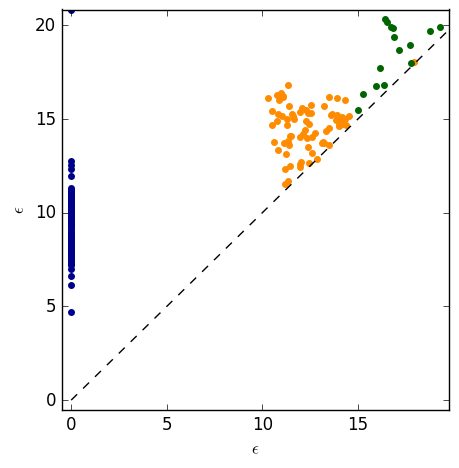

In [13]:
plot_persistence_diag(TDA_barcode_dim0, TDA_barcode_dim1, TDA_barcode_dim2)

#### Plot number of cells associated with largest void over time

In [14]:
lumen_1_cells = []
lumen_2_cells = []
lumen_3_cells = []
total_lumens = []
total_nuclei = []

for tp in range(0, stop=146)

    pos_data = load_postion_data("5", "12", tp)
    append!(total_nuclei, size(pos_data)[1])
    
    TDA_diag = eirene(transpose(pos_data), model="pc", maxdim=2);
    TDA_barcode_dim2 = barcode(TDA_diag, dim=2);
    dim2_bar_lengths = TDA_barcode_dim2[:,2] - TDA_barcode_dim2[:,1]
    s_idx = sortperm(dim2_bar_lengths, alg=MergeSort)
    dim2barcode_sorted_inc = TDA_barcode_dim2[s_idx,:]
    
    dim2_largest_h1 = classrep(TDA_diag, class=s_idx[end], dim=2)
    append!(lumen_1_cells, length(unique(dim2_largest_h1)))
    
    dim2_largest_h2 = classrep(TDA_diag, class=s_idx[end-1], dim=2)
    append!(lumen_2_cells, length(unique(dim2_largest_h2)))
    
    dim2_largest_h3 = classrep(TDA_diag, class=s_idx[end-2], dim=2)
    append!(lumen_3_cells, length(unique(dim2_largest_h3)))
    
    all_combined = hcat(dim2_largest_h1, dim2_largest_h2, dim2_largest_h3)
    append!(total_lumens, length(unique(all_combined)))
      
end

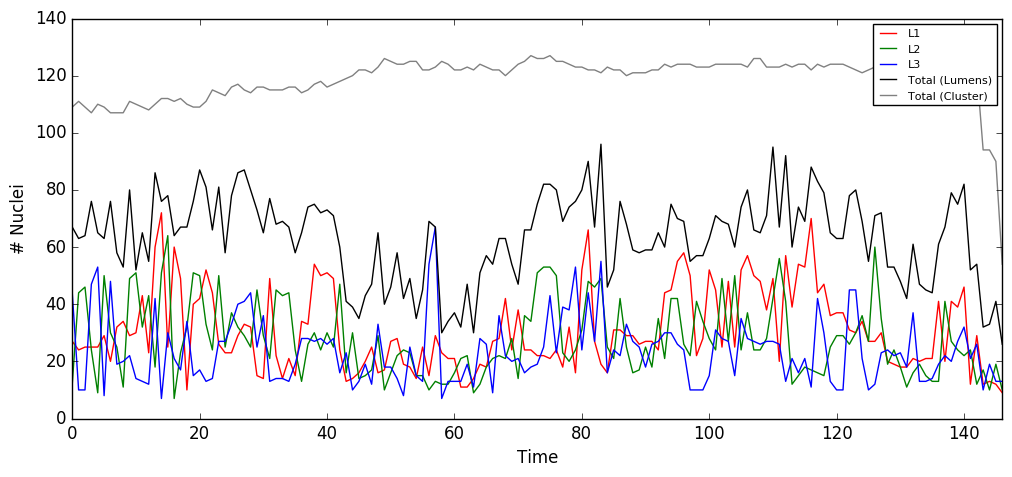

PyObject <matplotlib.legend.Legend object at 0x7fd472059518>

In [16]:
figure(figsize=(12,5), dpi=200)
plot(0:146, lumen_1_cells, color="red", label="L1")
plot(0:146, lumen_2_cells, color="green", label="L2")
plot(0:146, lumen_3_cells, color="blue", label="L3")
plot(0:146, total_lumens, color="black", label="Total (Lumens)")
plot(0:146, total_nuclei, color="gray", label="Total (Cluster)")
xlim([0, 146])
xlabel("Time")
ylabel("# Nuclei")
legend(fontsize=8)